In [1]:
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random

In [2]:

# --- Parameters ---
TRAIN_DIR = '/home/tanuj/DIP_project/dataset/train'  
TEST_DIR = '/home/tanuj/DIP_project/dataset/test'  
LABELS = {'NORMAL': 0, 'PNEUMONIA': 1}
BLOCK_SIZE = 4  # 4x4 blocks


In [3]:

# --- Advanced Preprocessing ---
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(img)



In [5]:

# --- Random Augmentation ---
def augment_image(img):
    #if random.random() < 0.5:
        #img = cv2.flip(img, 1)  # horizontal flip
    rows, cols = img.shape
    # Rotation
    angle = random.uniform(-10, 10)
    M_rot = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    img = cv2.warpAffine(img, M_rot, (cols, rows), borderMode=cv2.BORDER_REFLECT)
    # Translation
    tx = random.uniform(-0.1*cols, 0.1*cols)
    ty = random.uniform(-0.1*rows, 0.1*rows)
    M_trans = np.float32([[1, 0, tx], [0, 1, ty]])
    img = cv2.warpAffine(img, M_trans, (cols, rows), borderMode=cv2.BORDER_REFLECT)
    return img


In [6]:

# --- FFT ---
def compute_fft(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    return fshift

def compute_magnitude_spectrum(fshift):
    return 20 * np.log(np.abs(fshift) + 1e-8)


In [7]:

# --- Block-wise Feature Extraction ---
def compute_blockwise_features(magnitude_spectrum, block_size=BLOCK_SIZE):
    h, w = magnitude_spectrum.shape
    features = []
    block_h, block_w = h // block_size, w // block_size

    for i in range(block_size):
        for j in range(block_size):
            block = magnitude_spectrum[i*block_h:(i+1)*block_h, j*block_w:(j+1)*block_w]
            block = block / (np.sum(block) + 1e-8)
            energy = np.sum(block ** 2)
            block_safe = np.clip(block, 1e-8, None)
            entropy = -np.sum(block_safe * np.log2(block_safe))
            mean_coeff = np.mean(block)
            std_coeff = np.std(block)
            features.extend([energy, entropy, mean_coeff, std_coeff])
    return features


In [8]:

# --- Feature Extraction Wrapper ---
def extract_features(image_path, label, augment=False):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    if augment:
        img = augment_image(img)

    img_eq = apply_clahe(img)
    fshift = compute_fft(img_eq)
    magnitude_spectrum = compute_magnitude_spectrum(fshift)
    features = compute_blockwise_features(magnitude_spectrum)

    return features


In [9]:

# --- Load Dataset ---
def load_data(directory, augment=False):
    X, y, filenames = [], [], []
    for label in LABELS:
        folder = os.path.join(directory, label)
        for file in tqdm(os.listdir(folder), desc=f"Processing {label} in {directory}"):
            path = os.path.join(folder, file)
            features = extract_features(path, label, augment=augment)
            if features:
                X.append(features)
                y.append(LABELS[label])
                filenames.append(file)
    return np.array(X), np.array(y), filenames

# --- Load Data ---
X_train, y_train, files_train = load_data(TRAIN_DIR, augment=True)
X_test, y_test, files_test = load_data(TEST_DIR, augment=False)

# --- Save CSVs ---
pd.DataFrame(X_train, columns=[f"Feat_{i}" for i in range(X_train.shape[1])]).assign(Label=y_train, File=files_train).to_csv("xray_features_train.csv", index=False)
pd.DataFrame(X_test, columns=[f"Feat_{i}" for i in range(X_test.shape[1])]).assign(Label=y_test, File=files_test).to_csv("xray_features_test.csv", index=False)


Processing NORMAL in /home/tanuj/DIP_project/dataset/train:   0%|          | 0/1342 [00:00<?, ?it/s]

Processing NORMAL in /home/tanuj/DIP_project/dataset/train: 100%|██████████| 1342/1342 [04:32<00:00,  4.92it/s]
Processing PNEUMONIA in /home/tanuj/DIP_project/dataset/train: 100%|██████████| 3876/3876 [04:23<00:00, 14.73it/s]
Processing NORMAL in /home/tanuj/DIP_project/dataset/test: 100%|██████████| 234/234 [00:47<00:00,  4.94it/s]
Processing PNEUMONIA in /home/tanuj/DIP_project/dataset/test: 100%|██████████| 390/390 [00:19<00:00, 19.81it/s]


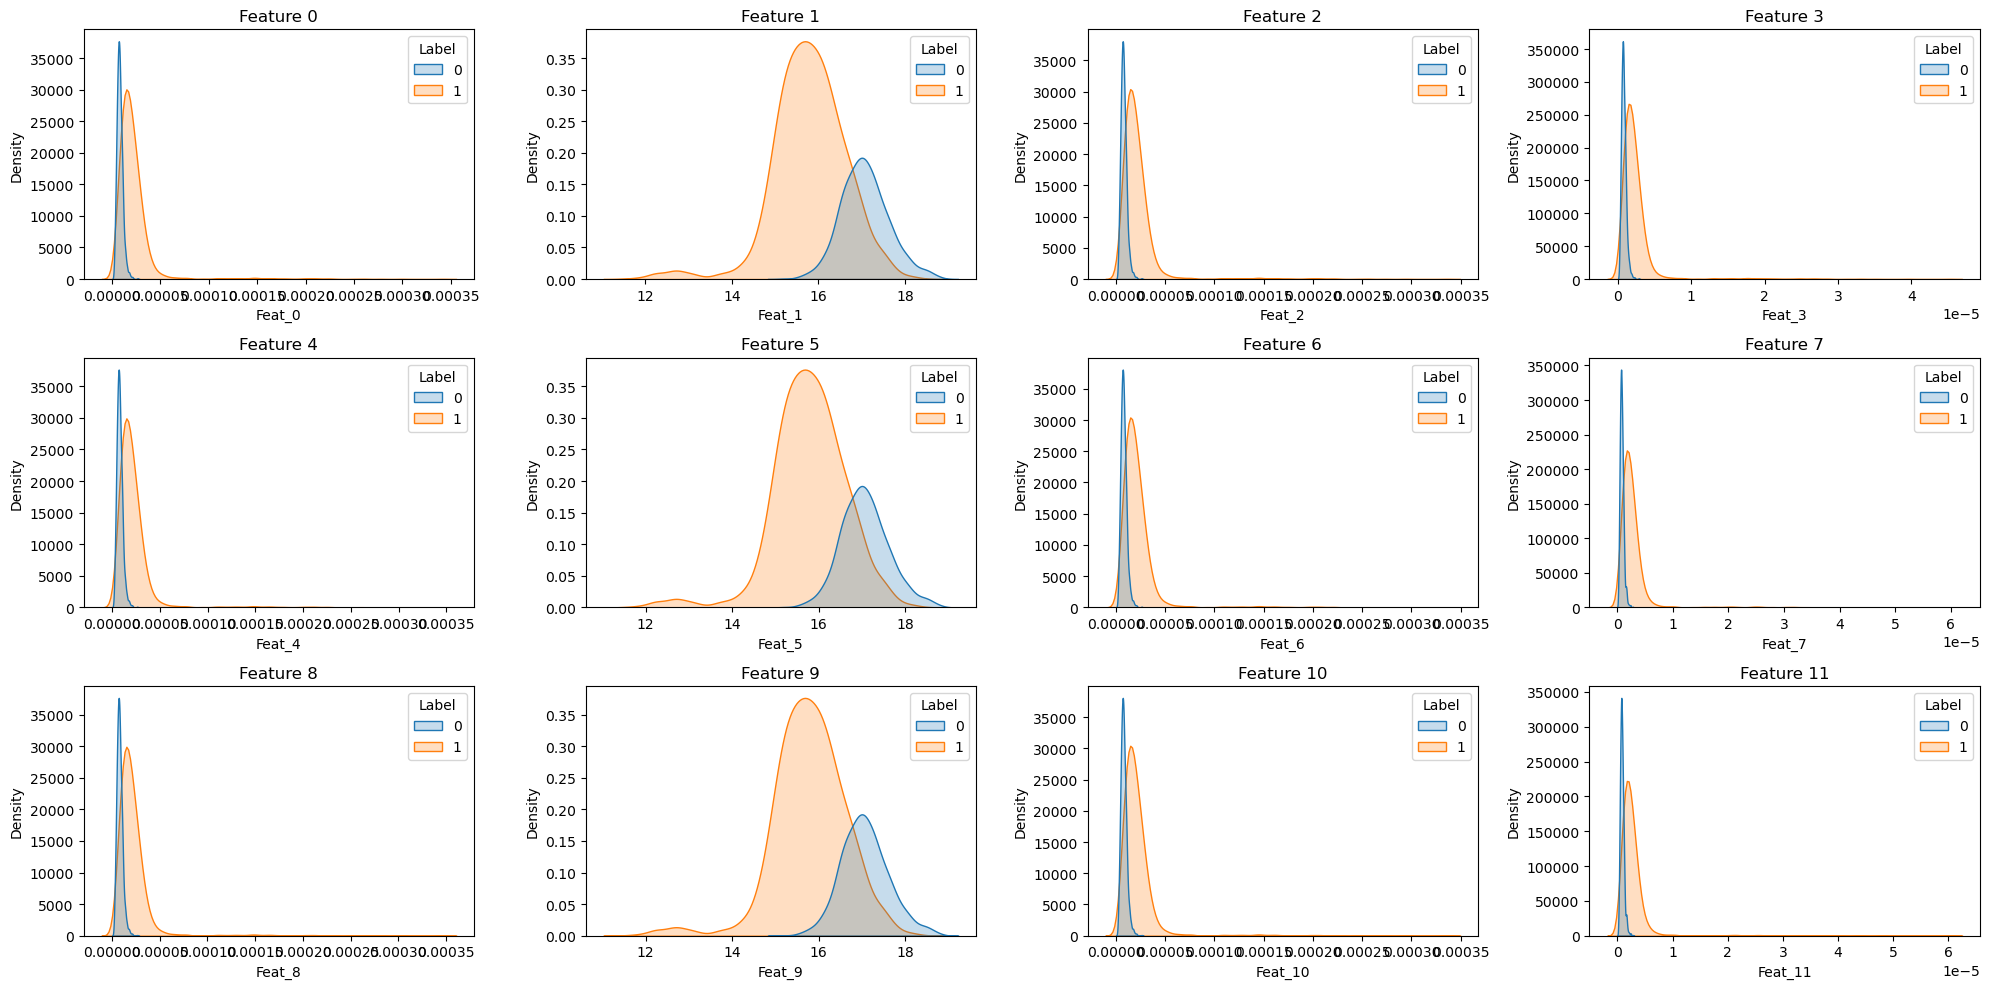

In [10]:

# --- Feature Visualization ---
df_train = pd.read_csv("xray_features_train.csv")
plt.figure(figsize=(20, 10))
for i in range(min(12, X_train.shape[1])):
    plt.subplot(3, 4, i+1)
    sns.kdeplot(data=df_train, x=f"Feat_{i}", hue="Label", fill=True)
    plt.title(f"Feature {i}")
plt.tight_layout()
plt.show()


In [11]:

# --- Model Training and Evaluation ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "SVM": SVC(kernel='rbf'),
    "Random Forest": RandomForestClassifier(n_estimators=300),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=300)
}

accuracies = {}
conf_matrices = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))
    print(f"{name} Accuracy:", acc)

    accuracies[name] = acc
    conf_matrices[name] = cm



Training SVM...

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.70      0.79       234
           1       0.84      0.95      0.89       390

    accuracy                           0.86       624
   macro avg       0.87      0.83      0.84       624
weighted avg       0.86      0.86      0.85       624

SVM Accuracy: 0.8573717948717948

Training Random Forest...

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       234
           1       0.89      0.84      0.86       390

    accuracy                           0.83       624
   macro avg       0.82      0.83      0.83       624
weighted avg       0.84      0.83      0.84       624

Random Forest Accuracy: 0.8349358974358975

Training Gradient Boosting...

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.85      

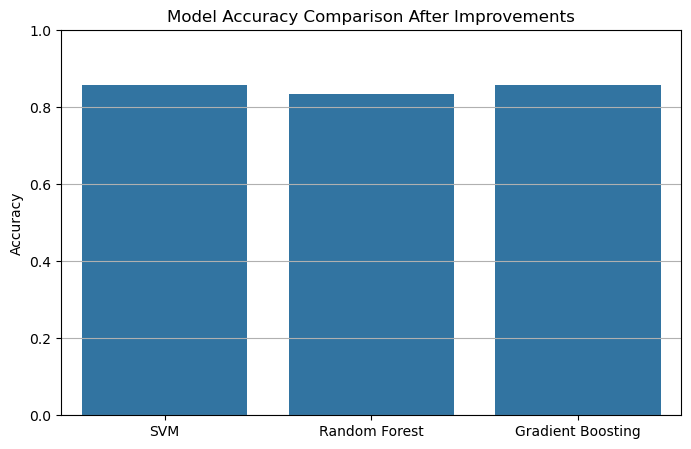

In [12]:

# --- Accuracy Visualization ---
plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title("Model Accuracy Comparison After Improvements")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()


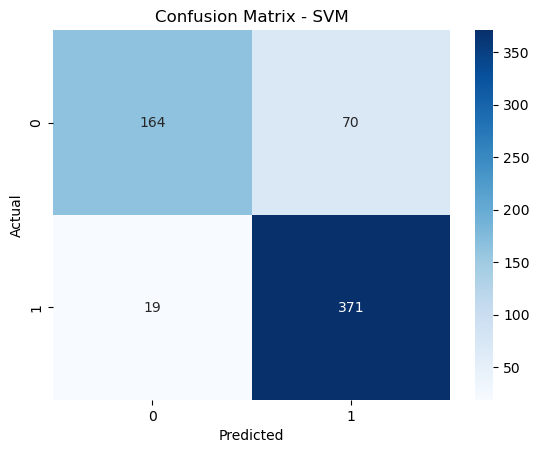

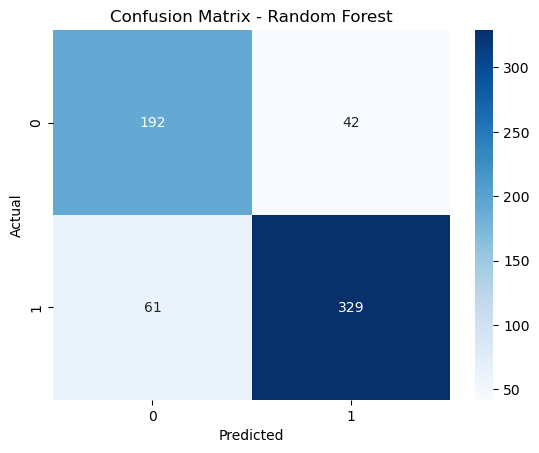

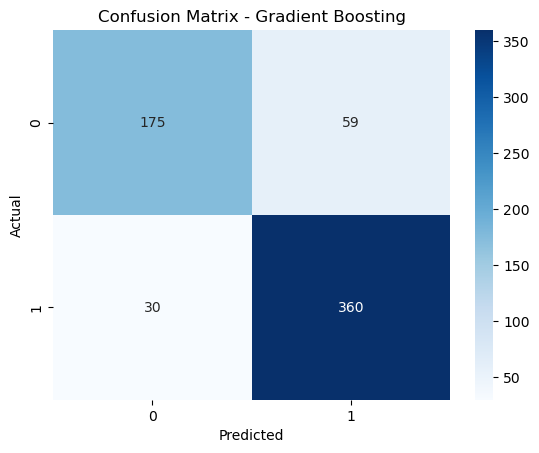

In [13]:

# --- Confusion Matrices ---
for name, cm in conf_matrices.items():
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


